# ⚠️ this notebook needs to be updated 

In [1]:
%matplotlib inline

In [2]:
import warnings

from pprint import pprint

import imageio
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from matplotlib.patches import Rectangle

warnings.filterwarnings("ignore")

import bioimageio.core
from bioimageio.core.prediction import predict_with_tiling
from bioimageio.core.prediction_pipeline import create_prediction_pipeline

In [3]:
model_resource = bioimageio.core.load_resource_description("10.5281/zenodo.6287342")

# change normalization mode from 'per_sampple' (as defined in the model's rdf) to 'per_dataset'
model_resource.inputs[0].preprocessing[0].kwargs["mode"] = "per_dataset"

In [ ]:
# load the example image for this model, which is stored in numpy file format
input_image_data = np.load(model_resource.test_inputs[0])

# # rotate image for better illustration of changing dataset statistics
# input_image_data = np.rot90(input_image_data.squeeze(), k=2)[None, None]

input_image = xr.DataArray(input_image_data, dims=model_resource.inputs[0].axes)
plt.imshow(input_image.squeeze())
plt.show()

### Illustrate dataset statistics vs sample (tile) statistics using small tiles on the test image

to illustrate the use of dataset statistics we create a dummy dataset by tiling the test input image with a small tile size.

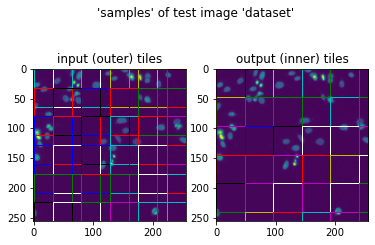

In [5]:
from bioimageio.core.prediction import get_tiling

tile_shape = dict(
    zip(
        model_resource.inputs[0].axes,
        np.asarray(model_resource.inputs[0].shape.min)
        + np.asarray(model_resource.inputs[0].shape.step),
    )
)

tiles = list(
    get_tiling(
        shape=input_image.shape,
        tile_shape=tile_shape,
        halo=dict(zip(model_resource.inputs[0].axes, model_resource.outputs[0].halo)),
        input_axes=model_resource.inputs[0].axes,
    )
)


def add_tile_box(ax, t):
    x = t["x"].start
    w = t["x"].stop - x
    y = t["y"].start
    h = t["y"].stop - y

    box = Rectangle(
        (x, y),
        w,
        h,
        linewidth=1,
        edgecolor=np.random.choice(list("rgbcmykw")),
        facecolor="none",
    )
    ax.add_patch(box)


fig, ax = plt.subplots(1, 2)
fig.suptitle("'samples' of test image 'dataset'")
ax[0].set_title("input (outer) tiles")
ax[0].imshow(input_image.squeeze())
for t in tiles:
    add_tile_box(ax[0], t.outer)

ax[1].set_title("output (inner) tiles")
ax[1].imshow(input_image.squeeze())
for t in tiles:
    add_tile_box(ax[1], t.inner)

plt.show()

# create dummy dataset with tiles as samples
dataset = [input_image[t.inner] for t in tiles]

#### using 'create_prediction_pipeline' with different arguments.

In [6]:
def process_dataset(pp, dataset):
    stats = pp._ipt_stats.compute_measures()["per_dataset"]
    print(f"initial stats:")
    pprint(
        None
        if not stats
        else {k: f"{v.item():.2f}" for k, v in stats["input0"].items()}
    )
    stats = {}
    sample_dataset = [{"input0": s} for s in dataset]
    [pp.apply_preprocessing(s, stats) for s in sample_dataset]
    print(f"final stats:")
    pprint(
        None
        if not stats
        else {k: f"{v.item():.2f}" for k, v in stats["per_dataset"]["input0"].items()}
    )
    return [s["input0"] for s in sample_dataset]


# accumulate dataset statistics exclusively while processing samples (no initial dataset statistics are computed)
with create_prediction_pipeline(
    bioimageio_model=model_resource,
    # dataset_for_initial_statistics=tuple(),  # an empty dataset is the default
) as pp:
    wo_init_dataset_stats = process_dataset(pp, dataset)

computing dataset statistics: 0it [00:00, ?it/s]


initial stats:
None
final stats:
{Mean(axes=('c', 'y', 'x')): '17.72',
 Std(axes=('c', 'y', 'x')): '20.25',
 Var(axes=('c', 'y', 'x')): '410.08'}


In [13]:
# accumulate dataset statistics exclusively while processing samples for a limited number of samples
with create_prediction_pipeline(
    bioimageio_model=model_resource,
    update_dataset_stats_for_n_samples=len(dataset) // 2,
) as pp:
    wo_init_dataset_stats_limit = process_dataset(pp, dataset)

computing dataset statistics: 0it [00:00, ?it/s]


initial stats:
None
final stats:
{Mean(axes=('c', 'y', 'x')): '20.39',
 Std(axes=('c', 'y', 'x')): '23.98',
 Var(axes=('c', 'y', 'x')): '574.98'}


In [14]:
# initialize dataset statistics with first n samples and keep update dataset statistics after the n sample
# this assumes that the n samples present in 'dataset_for_initial_statistics' are those that will be processed
# by the prediction pipeline and thus should not update the dataset statistics.
# Use 'update_dataset_stats_after_n_samples=0' if that is not your use case.
with create_prediction_pipeline(
    bioimageio_model=model_resource,
    dataset_for_initial_statistics=dataset[: len(dataset) // 2],
    # update_dataset_stats_after_n_samples=None,  # defaults to len(dataset_for_initial_statistics)
) as pp:
    partial_init_dataset_stats = process_dataset(pp, dataset)

computing dataset statistics: 18it [00:00, 484.45it/s]


initial stats:
{Mean(axes=('c', 'y', 'x')): '20.39',
 Std(axes=('c', 'y', 'x')): '23.98',
 Var(axes=('c', 'y', 'x')): '574.98'}
final stats:
{Mean(axes=('c', 'y', 'x')): '17.72',
 Std(axes=('c', 'y', 'x')): '20.25',
 Var(axes=('c', 'y', 'x')): '410.08'}


In [15]:
# compute dataset statistics on all samples
# (in this case we should really use the non-overlapping tiles as samples in dataset_for_initial_statistics)
with create_prediction_pipeline(
    bioimageio_model=model_resource,
    dataset_for_initial_statistics=dataset,
    update_dataset_stats_for_n_samples=0,  # if you call the prediciton pipeline more then len(dataset)
    # times you might want to set this to zero to avoid further updates to the dataset statistics
) as pp:
    only_init_dataset_stats = process_dataset(pp, dataset)

computing dataset statistics: 36it [00:00, 513.27it/s]


initial stats:
{Mean(axes=('c', 'y', 'x')): '17.72',
 Std(axes=('c', 'y', 'x')): '20.25',
 Var(axes=('c', 'y', 'x')): '410.08'}
final stats:
{Mean(axes=('c', 'y', 'x')): '17.72',
 Std(axes=('c', 'y', 'x')): '20.25',
 Var(axes=('c', 'y', 'x')): '410.08'}


### image comparisons

In [16]:
def untile(outputs):
    untiled = xr.DataArray(
        np.empty((1, 2, *input_image.squeeze().shape)),
        dims=model_resource.outputs[0].axes,
    )
    for out, t in zip(outputs, tiles):
        untiled[t.inner] = out[0]

    return untiled.data.squeeze()


# prepare image comparisons
titles = [
    "wo_init_dataset_stats",
    "wo_init_dataset_stats_limit",
    "partial_init_dataset_stats",
    "only_init_dataset_stats",
]
images = [
    untile(out)[0]
    for out in [
        wo_init_dataset_stats,
        wo_init_dataset_stats_limit,
        partial_init_dataset_stats,
        only_init_dataset_stats,
    ]
]

#### comparison of preprocessed images

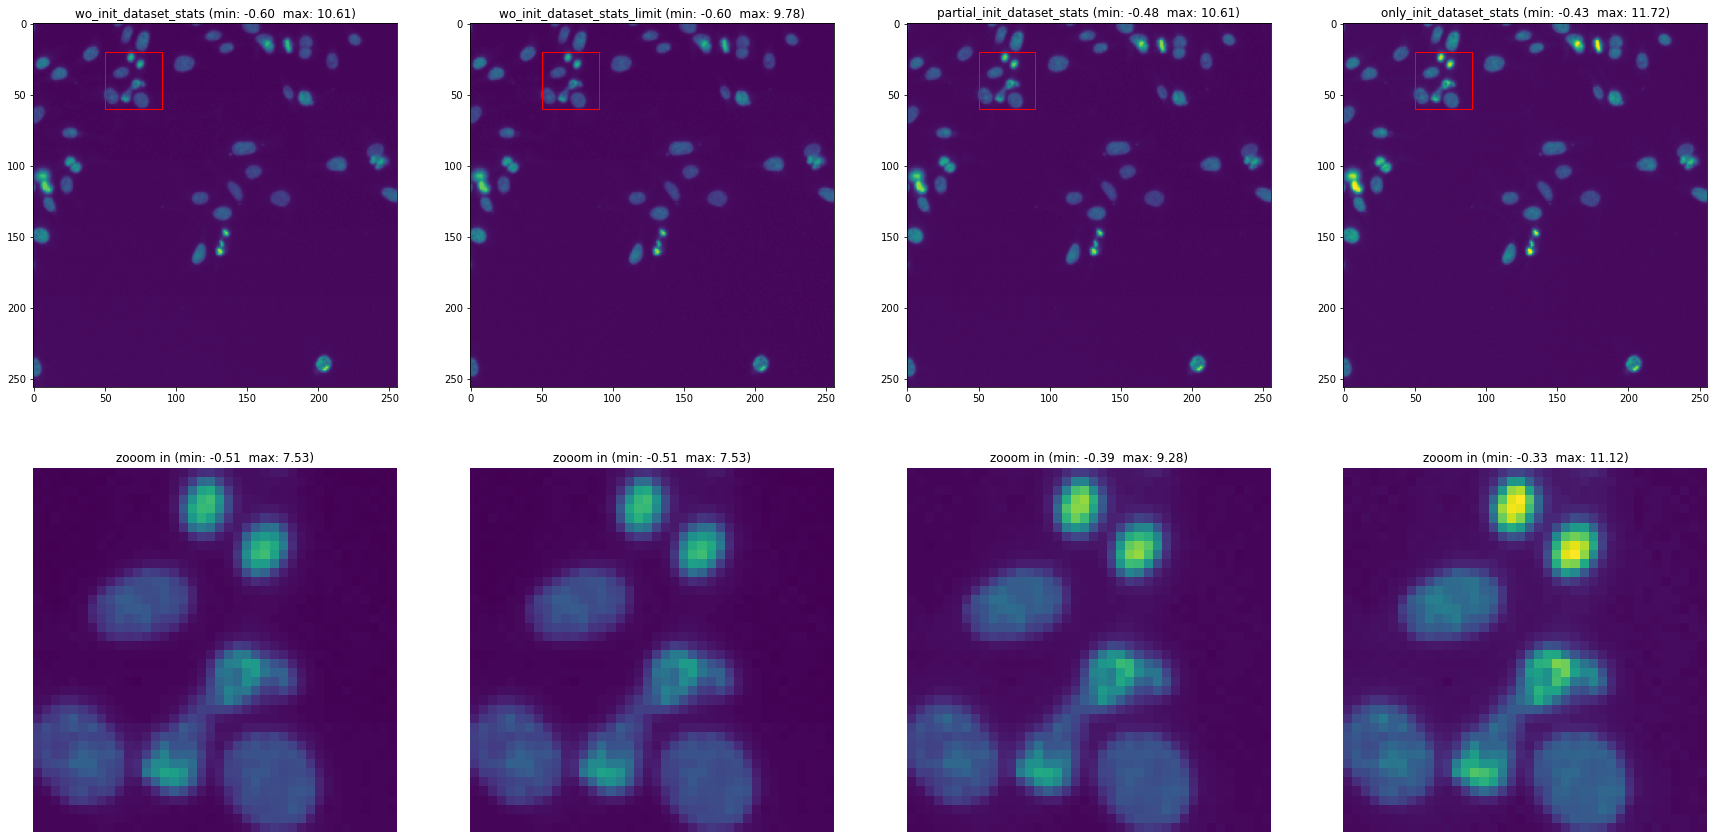

In [30]:
fig, axes = plt.subplots(2, 4, figsize=(30, 15))
for ax in axes[1]:
    ax.set_axis_off()

zoom_roi = np.s_[20:60, 50:90]


def get_box():
    return Rectangle(
        (zoom_roi[1].start, zoom_roi[0].start),
        zoom_roi[1].stop - zoom_roi[1].start,
        zoom_roi[0].stop - zoom_roi[0].start,
        linewidth=1,
        edgecolor="r",
        facecolor="none",
    )


vmin = min([img.min() for img in images])
vmax = max([img.max() for img in images])
zoom_vmin = min([img[zoom_roi].min() for img in images])
zoom_vmax = max([img[zoom_roi].max() for img in images])

for i, (title, img) in enumerate(zip(titles, images)):
    axes[0, i].imshow(img, vmin=vmin, vmax=vmax)
    axes[0, i].add_patch(get_box())
    axes[0, i].set_title(f"{title} (min: {img.min():.2f}  max: {img.max():.2f})")
    axes[1, i].imshow(img[zoom_roi], vmin=zoom_vmin, vmax=zoom_vmax)
    axes[1, i].set_title(
        f"zooom in (min: {img[zoom_roi].min():.2f}  max: {img[zoom_roi].max():.2f})"
    )

plt.show()

#### comparison of image differences

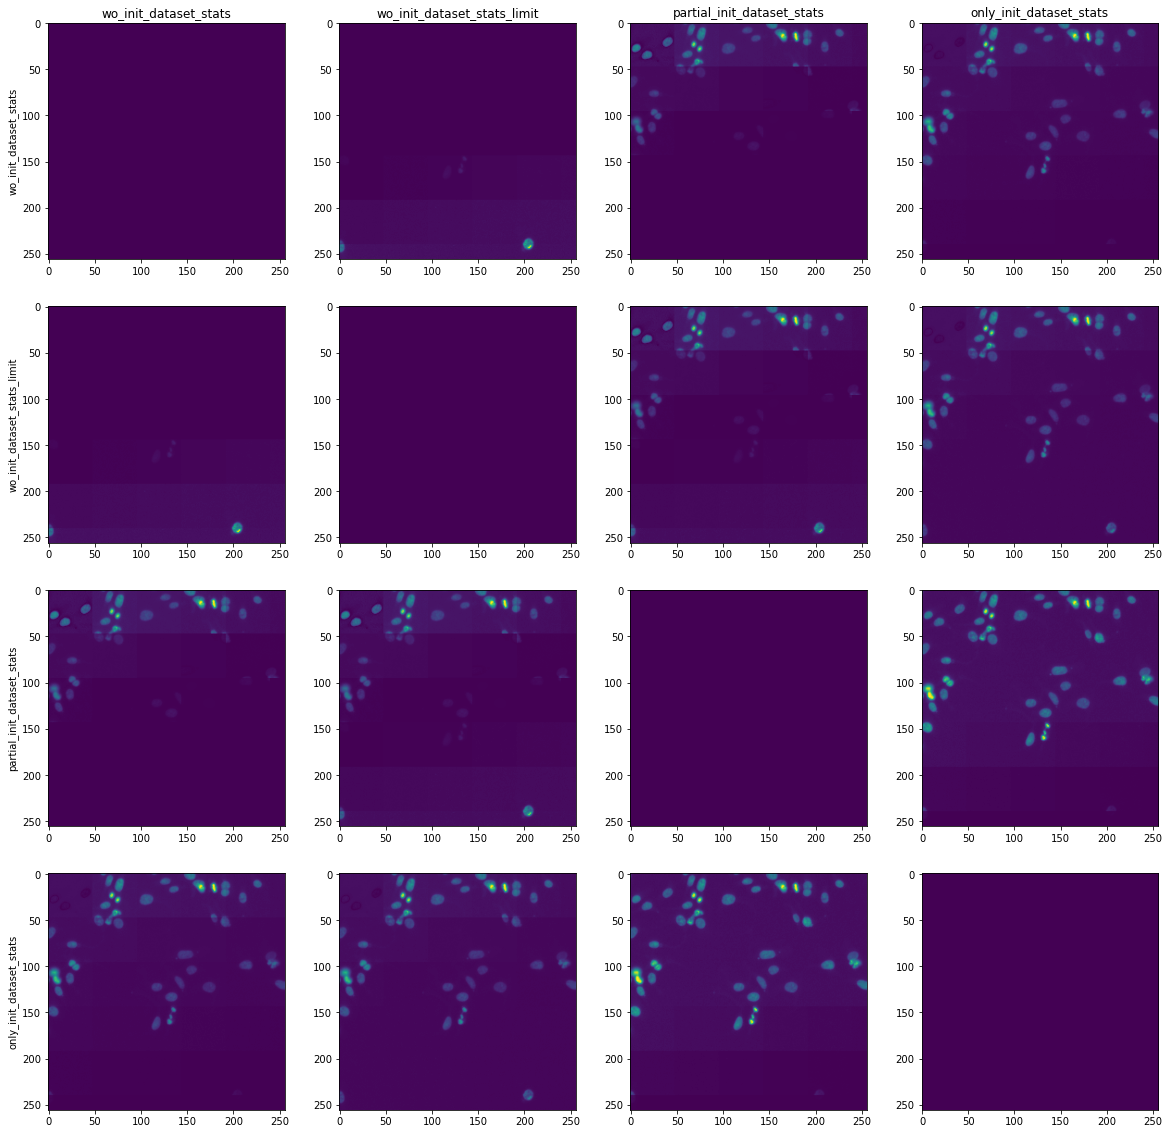

In [24]:
fig, ax = plt.subplots(4, 4, figsize=(20, 20))
for ai, (atitle, a) in enumerate(zip(titles, images)):
    for bi, (btitle, b) in enumerate(zip(titles, images)):
        ax[ai, bi].imshow(np.abs(a - b))
        if ai == 0:
            ax[ai, bi].set_title(btitle)
        if bi == 0:
            ax[ai, bi].set_ylabel(atitle)

plt.show()